In [1]:
from glider_model import *
import numpy as np

In [16]:
glider = GliderPitchSim()
glider._wing_alpha = 0 * np.pi / 180
glider._horz_stab_alpha = -8 * np.pi / 180
glider._pos_center_lift = 25e-3
glider._pos_horz_stab = 50e-2

glider.init_conditions((6, 0), 0*np.pi/180)
for _ in range(1000):
    glider.step()
glider.finalize_lists()

(-0.005, 0.005)

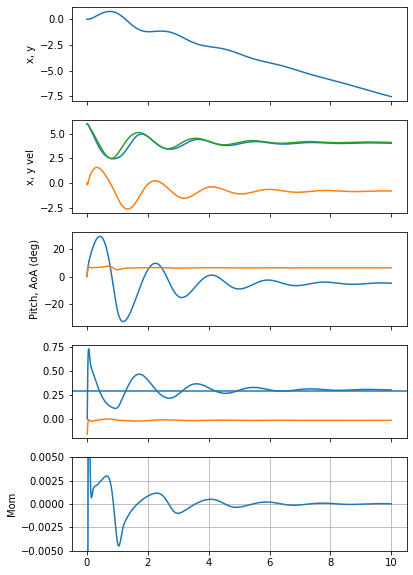

In [17]:
f, ax = plt.subplots(5, 1, sharex=True, figsize=(6, 10))

#ax[0].plot(glider._t, glider._r[:, 0])
ax[0].plot(glider._t, glider._r[:, 1])
ax[0].set_ylabel('x, y')

ax[1].plot(glider._t, glider._v[:, 0])
ax[1].plot(glider._t, glider._v[:, 1])
ax[1].plot(glider._t, np.linalg.norm(glider._v, axis=1))
ax[1].set_ylabel('x, y vel')

ax[2].plot(glider._t, glider._pitch*180/np.pi)
ax[2].plot(glider._t, (glider._pitch - np.arctan2(glider._v[:, 1], glider._v[:, 0])) * 180 / np.pi)
ax[2].set_ylabel('Pitch, AoA (deg)')

ax[3].plot(glider._t[1:], glider._Fwing)
ax[3].plot(glider._t[1:], glider._Fstab)
ax[3].axhline(glider._mass * G)
#ax[3].plot(glider._t, glider._w * 180/np.pi)
#ax[3].set_ylabel(r'$\omega$ (dps)')

ax[4].plot(glider._t[1:], glider._mom.sum(axis=1))
ax[4].set_ylabel('Mom')
ax[4].grid(True)
ax[4].set_ylim((-.005, .005))

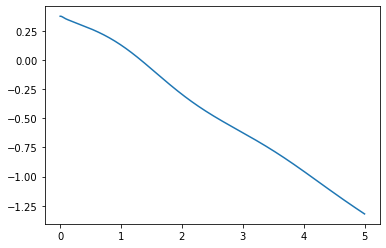

In [4]:
plt.plot(glider._t, .5*glider._mass*np.linalg.norm(glider._v, axis=1)**2 + glider._mass * G * glider._r[:, 1])